In [1]:
%matplotlib inline


# Univariate Feature Selection Selection de caracteristique univariée

Ce bloc-notes est un exemple d'utilisation de la sélection de caractéristiques univariées pour améliorer la précision de la classification sur un jeu de données bruyant.

Dans cet exemple, certaines caractéristiques bruyantes (non informatives) sont ajoutées au jeu de données de l'iris. La machine à vecteurs de support (SVM) est utilisée pour classer l'ensemble de données avant et après l'application de la sélection de caractéristiques univariées. Pour chaque caractéristique, nous traçons les valeurs de p pour la sélection de caractéristique univariée et les poids correspondants des SVM. Avec cela, nous comparerons la précision du modèle et examinerons l'impact de la sélection de caractéristiques univariées sur les poids du modèle.


## Generate sample data




In [2]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# The iris dataset
X, y = load_iris(return_X_y=True)

# Some noisy data not correlated
E = np.random.RandomState(42).uniform(0, 0.1, size=(X.shape[0], 20)) # 20 variables

# Add the noisy data to the informative features  
"""on rajoute un bruit de 20 variables à nos 4 variables"""
X = np.hstack((X, E))

# Split dataset to select feature and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

In [9]:
X.shape

(150, 24)

## Univariate feature selection f_classif = F ANOVA

Sélection de caractéristiques univariées avec test F pour la notation des caractéristiques. Nous utilisons la fonction de sélection par défaut pour sélectionner les quatre caractéristiques les plus importantes.



In [7]:
from sklearn.feature_selection import SelectKBest, f_classif

selector = SelectKBest(f_classif, k=4)  """ sélectionne les variables en focntion des4 score les + élevés """
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()   # /= <=> scores = scores / scores.max()    ( raccourcis d'opérateur comme := ) TAPER help('/=')

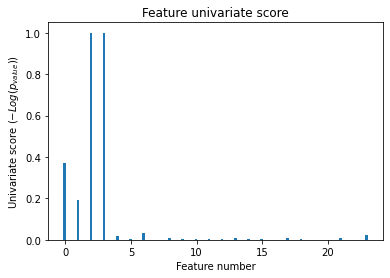

In [5]:
import matplotlib.pyplot as plt

X_indices = np.arange(X.shape[-1])
plt.figure(1)
plt.clf()  # effacer la figure courante
plt.bar(X_indices - 0.05, scores, width=0.2)
plt.title("Feature univariate score")
plt.xlabel("Feature number")
plt.ylabel(r"Univariate score ($-Log(p_{value})$)")
plt.show()

Dans l'ensemble des fonctionnalités, seules les 4 fonctionnalités d'origine sont significatives. Nous pouvons voir qu'ils ont le score le plus élevé avec la sélection de caractéristiques univariées.
Le test de ANOVA a donc marché

## Compare with SVMs

Without univariate feature selection



In [16]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC

clf = make_pipeline(MinMaxScaler(), LinearSVC())
clf.fit(X_train, y_train)
print(
    "Classification accuracy without selecting features: {:.3f}".format(
        clf.score(X_test, y_test)
    )
)

svm_weights = np.abs(clf[-1].coef_).sum(axis=0)
svm_weights /= svm_weights.sum()

Classification accuracy without selecting features: 0.789


After univariate feature selection



In [17]:
clf_selected = make_pipeline(SelectKBest(f_classif, k=4), MinMaxScaler(), LinearSVC())
clf_selected.fit(X_train, y_train)
print(
    "Classification accuracy after univariate feature selection: {:.3f}".format(
        clf_selected.score(X_test, y_test)
    )
)

svm_weights_selected = np.abs(clf_selected[-1].coef_).sum(axis=0)
svm_weights_selected /= svm_weights_selected.sum()

Classification accuracy after univariate feature selection: 0.868


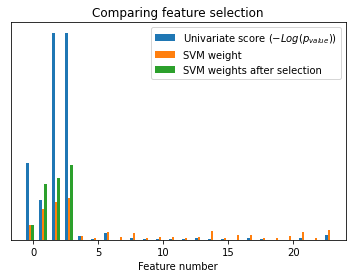

In [18]:
plt.bar(
    X_indices - 0.45, scores, width=0.2, label=r"Univariate score ($-Log(p_{value})$)"
)

plt.bar(X_indices - 0.25, svm_weights, width=0.2, label="SVM weight")

plt.bar(
    X_indices[selector.get_support()] - 0.05,
    svm_weights_selected,
    width=0.2,
    label="SVM weights after selection",
)

plt.title("Comparing feature selection")
plt.xlabel("Feature number")
plt.yticks(())
plt.axis("tight")
plt.legend(loc="upper right")
plt.show()

Without univariate feature selection, the SVM assigns a large weight
to the first 4 original significant features, but also selects many of the
non-informative features. Applying univariate feature selection before
the SVM increases the SVM weight attributed to the significant features,
and will thus improve classification.

